In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
# import wandb

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import LSTM
from keras.layers import Input, Dense, Dropout
from keras import Model

In [3]:
!git clone https://github.com/Bara-Elba/Stock-prediction.git

Cloning into 'Stock-prediction'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 3), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (16/16), 1.21 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
!ls

sample_data  Stock-prediction


# Workflow :
### 1- read and clean the data
### 2- Visualize the data
### 3- split to train and test datasets
### 4- build and train an LSTM model
### 5- Visualization of the results

In [6]:
df = pd.read_csv('/content/Stock-prediction/Gold Price (2013-2023).csv')

In [7]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB
None


In [9]:
print(df.describe())


              Date     Price      Open      High       Low   Vol. Change %
count         2583      2583      2583      2583      2583   2578     2583
unique        2583      2072      2061      2044      2019   1550      474
top     12/30/2022  1,294.30  1,284.00  1,220.00  1,314.00  0.02K    0.00%
freq             1         5         5         6         5     48       29


In [10]:
df.drop(columns=['Vol.','Change %'], inplace=True)

In [11]:
df.head()

,Date,Price,Open,High,Low
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80"
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20"
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20"
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00"
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55"


In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'],ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
df.replace(',','',regex=True, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2583 non-null   datetime64[ns]
 1   Price   2583 non-null   object        
 2   Open    2583 non-null   object        
 3   High    2583 non-null   object        
 4   Low     2583 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 101.0+ KB


In [15]:
df['Price'] = df['Price'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

In [16]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title='Date',yaxis_title='Price',title={'text':'Gold Price','y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'}, plot_bgcolor='rgba(255,223,0,0.9)')

In [17]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

<function matplotlib.pyplot.show(close=None, block=None)>

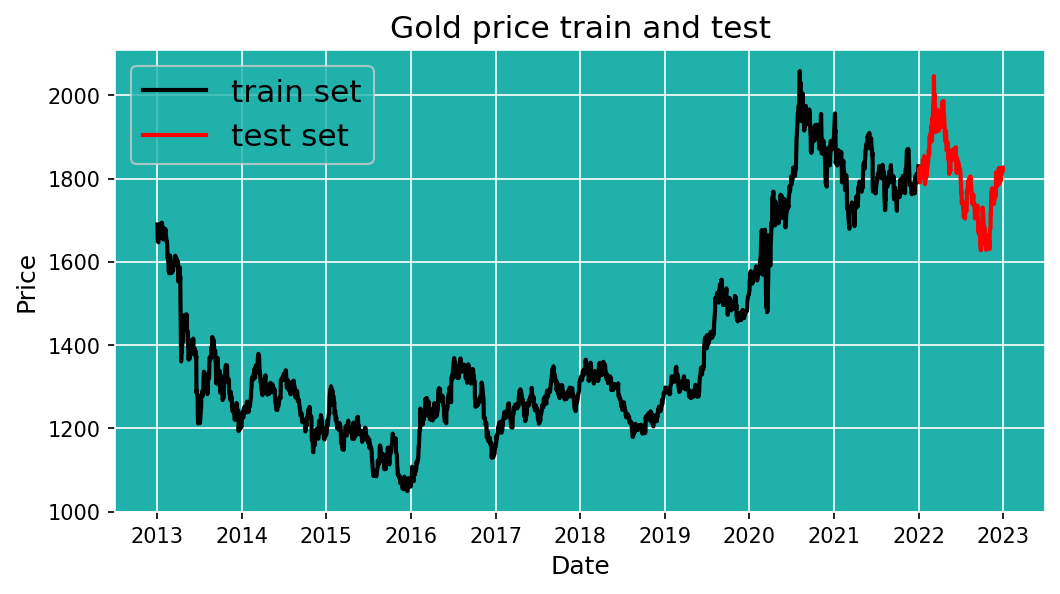

In [80]:
plt.figure(figsize=(8,4), dpi=150)
plt.rcParams['axes.facecolor']= 'lightseagreen'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size],color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:],color='red', lw=2)
plt.title('Gold price train and test', fontsize=15)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(['train set', 'test set'], loc='upper left', prop={'size':15})

plt.grid(color='white')
plt.show

In [19]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [20]:
window_size = 60

In [21]:
train_data = df.Price[-test_size-60:]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [22]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])

In [23]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [24]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i,0])

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1) )
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1) )
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [27]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (260, 60, 1)
X_test shape:  (260, 60, 1)
y_train shape:  (260, 1)
y_test shape:  (260, 1)


In [61]:
def LSTM_model():
    m_input = Input(shape=(window_size,1))
    x = LSTM(units=64,return_sequences=True)(m_input)
    x = Dropout(0.2)(x)
    x = LSTM(units=64,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units= 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation = 'softmax')(x)
    output = Dense(1)(x)

    model = Model(inputs = m_input, outputs= [output])
    model.compile(loss = 'mean_squared_error', optimizer = 'Nadam')
    model.summary()

    return model

In [62]:
model = LSTM_model()
history = model.fit(X_train, y_train, epochs = 150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_10 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_12 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_11 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0   

In [63]:
result = model.evaluate( X_test, y_test)
y_pred = model.predict(X_test)

9/9 [==============================] - 1s 6ms/step


In [67]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1- MAPE

In [68]:
print('Test loss', result)
print('Test MAPE', MAPE)
print('Test Accuracy', Accuracy)

Test loss 0.008153661154210567
Test MAPE 0.09957375512945749
Test Accuracy 0.9004262448705425


In [69]:
# print(history.history['val_loss'])

[0.4176833927631378, 0.19953402876853943, 0.11518058180809021, 0.08577828854322433, 0.07190260291099548, 0.06236002966761589, 0.054641999304294586, 0.04806370288133621, 0.042256876826286316, 0.03710126876831055, 0.03254363313317299, 0.028504732996225357, 0.024915505200624466, 0.02167157083749771, 0.01878216676414013, 0.016283027827739716, 0.01404028944671154, 0.012099013663828373, 0.010382427833974361, 0.008929286152124405, 0.007648634258657694, 0.00653415871784091, 0.005550017114728689, 0.0047032530419528484, 0.003951601684093475, 0.003310969565063715, 0.002778715919703245, 0.0023371251299977303, 0.0019888279493898153, 0.0016943832160905004, 0.0014469033339992166, 0.001250671106390655, 0.0010917994659394026, 0.0009594519506208599, 0.000853878678753972, 0.000772099825553596, 0.0007076613837853074, 0.0006469533545896411, 0.0005993081140331924, 0.0005627010832540691, 0.0005369475693441927, 0.0005156400729902089, 0.00050239177653566, 0.0004953021416440606, 0.0004908224800601602, 0.0004889

NameError: name 'arange' is not defined

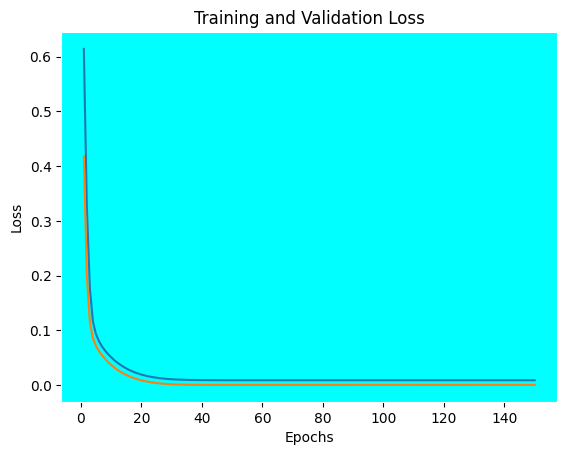

In [70]:
train_values = history.history['loss']
val_values = history.history['val_loss']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 151)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

In [71]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

In [75]:
plt.figure(figsize=(8,4), dpi=150)
plt.rcParams['axes.facecolor']= 'cyan'
plt.rc('axes', edgecolor='white')
plt.plot(df.['Date'].iloc[:-test_size], scaler.inverse_transform(train_data),color='black', lw=2)
plt.plot(df.['Date'].iloc[-test_size:], y_test_true, color='green', lw=2)
plt.plot(df.['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model performance ', fontsize=15)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(['Train data', 'Actuale test data', 'Predicted data'], loc='upper left', prop={'size':15})

plt.grid(color='white')
plt.show

SyntaxError: invalid syntax (<ipython-input-75-30d67a2d993c>, line 4)

In [ ]:
sddd